In [1]:
import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
import time

# Datasets utilisés pour tester les algorithmes

En premier dataset, on prend un mélange gaussien en dimension 3 pour pouvoir tester rapidement les algorithmes.\
On normalise les données, ce qui est nécessaire pour ne pas faire exploser les exponentielles qui seront utilisées par la suite. 

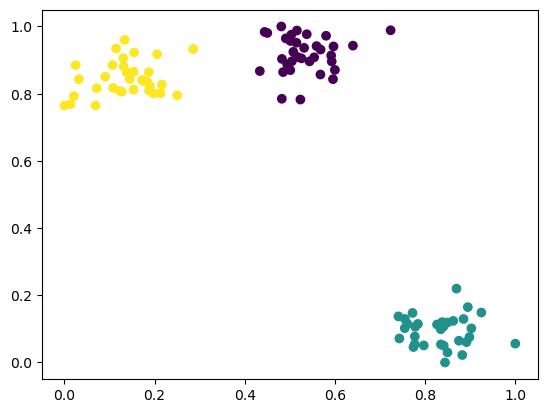

In [2]:
from sklearn.datasets import make_blobs

Xb, yb = make_blobs(n_features=3, random_state=42)
Xb = (Xb - Xb.min(axis=0))/(Xb.max(axis=0) - Xb.min(axis=0))
plt.scatter(Xb[:,0], Xb[:,1], c=yb)

Le deuxième dataset utilisé est digits de sklearn. Il contient des images de nombres écrits à la main sur une image de 8x8 pixels

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
Xd = digits.data
yd = digits.target

Text(0.5, 1.0, 'chiffre 1')

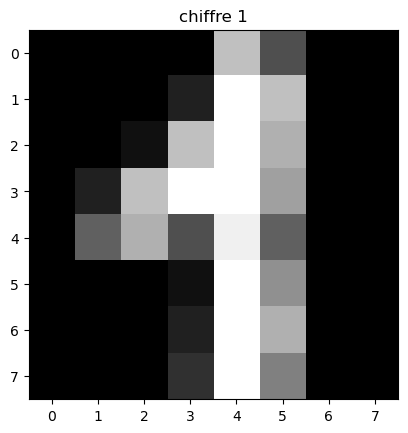

In [4]:
i = 42
plt.imshow(Xd[i].reshape(8, 8), cmap='gray')
plt.title(f"chiffre {yd[i]}")

# Détermination des $\sigma_i$

Dans SNE et T-SNE, il est nécessaire de déterminer les $\sigma_i$ qui correspondent aux écarts types des gaussiennes centrées sur les points des différents datasets
On utilise le mélange gaussien

In [41]:
# Fonction pour déterminer les pj|i à i fixé
def compute_p_i(X, i, sigma_i):
    sqeuclidean = lambda x: np.inner(x, x)
    n = len(X)
    p_i = np.zeros(n)
    for j in range(n):
        if i == j:
            continue
        
        # on ajoute un petit epsilon de 5e-5 pour éviter que l'exponentielle donne un chiffre inférieur au 0 machine.
        p_i[j] = np.exp(-sqeuclidean(X[i] - X[j])/(2*sigma_i**2 + 5e-5))
    return p_i / p_i.sum()

# permet d'obtenir la perplexité à partir des données et d'un certain sigma pour un i fixé
def compute_perp_i(X, i, sigma_i):
    p_i = compute_p_i(X, i, sigma_i)
    return (p_i**(-p_i)).prod()

On peut ensuite tracer l'évolution de la perplexité en fonction du $\sigma$ choisi.

(1.0000066087320876, 98.99941220590198)

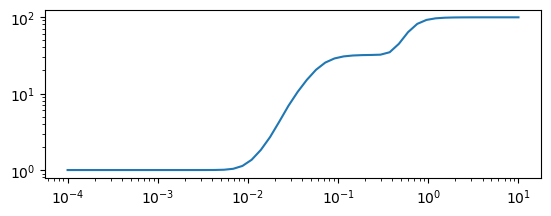

In [42]:
i = 5
sigma_list = np.logspace(-4, 1)
l = np.zeros(len(sigma_list))
for k in range(len(sigma_list)):
    sigma = sigma_list[k]
    l[k] = compute_perp_i(Xb, i, sigma)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(sigma_list, l)

ax.set_xscale('log')
ax.set_yscale('log')
l[0], l[-1]

On remarque que la fonction est croissante et que les valeurs suggérées pour la perpléxité (entre 5 et 100) sont justifiées.\
On va par la suite utiliser un algorithme de dicothomie pour trouver le $\sigma$ qui correspond à la perpléxité souhaitée.

# Implémentation de l'algorithme SNE

## class History

Cette classe est implémentée pour définir l'objet qui sera retournée lors du fit du SNE. Il permet de faciliter l'affichage de graphiques et de produire un .gif pour voir l'évolution de Y en fonction des itérations.

In [7]:
from matplotlib.animation import FuncAnimation

class History:
    loss: npt.NDArray[np.float64]
    Y: npt.NDArray[np.float64]
    alpha: npt.NDArray[np.float64]
    
    def __init__(self, loss: npt.NDArray[np.float64], Y: npt.NDArray[np.float64], alpha):
        self.Y = Y
        self.loss = loss
        self.alpha = alpha
    
    # Permet de concaténer deux instances de la classe History
    def concatenate(self, h2: 'History') -> 'History':
        loss = np.concatenate((self.loss, h2.loss))
        Y = np.concatenate((self.Y, h2.Y))
        alpha = np.concatenate((self.alpha, h2.alpha))
        return History(loss, Y, alpha)
        
    # Permet d'afficher la loss
    def plot_loss(self):
        plt.plot(self.loss)
        
    def plot_alpha(self):
        plt.plot(self.alpha)
    
    # Permet d'afficher la configuration de Y à l'itération i. Par défaut c'est la dernière configue qui est affichée.
    def plot_Y_i(self,y , i=-1):
        plt.scatter(self.Y[i, :, 0], self.Y[i, :, 1], c=y)
        
    # Permet de créer un .gif à partir du Y
    def anim_Y(self, y: npt.NDArray[np.float64], name: str, interval=100, folder=".", prop=1):
        fig, ax = plt.subplots()
        
        Y = self.Y[::prop]
        
        def animation(i, Y, y, prop):
            ax.clear()
            ax.set_title(f'{name} : Frame {i*prop}')
            ax.scatter(Y[i, :, 0], Y[i, :, 1], c=y)


        update = lambda frame: animation(frame, Y, y, prop)

        anim = FuncAnimation(fig, update, len(Y), repeat=False, interval=interval)

        anim.save(f"{folder}/{name}.gif")

## class SNE

In [24]:
class SNE:
    perp: int # chosen aimed perplexity
    P: npt.NDArray[np.float64] # P matrix
    Q: npt.NDArray[np.float64] # Q matrix
    n: int # number of sapmles for the dimension reduction
    
    def __init__(self, X, perp):
        self.n = len(X)
        self.P = np.zeros((self.n, self.n))
        self.Q = np.zeros((self.n, self.n))
        self.sqeuclidean = lambda x: np.inner(x, x) # ||x||²
        
        for i in range(self.n):
            self.find_sigma_i(X, i, perp)
    
    # Compute i-th row of the P matrix
    def compute_p_i(self, X: npt.NDArray[np.float64], i: int, sigma_i: float):
        for j in range(self.n):
            if i == j:
                continue
            self.P[i, j] = np.exp(-self.sqeuclidean(X[i] - X[j])/(2*sigma_i**2 + 5e-5))
        self.P[i] /= self.P[i].sum()

    # Compute the perplexity for a row of P with a sigma_i
    def compute_perp_i(self, X, i, sigma_i):
        self.compute_p_i(X, i, sigma_i)
        return (self.P[i]**(-self.P[i])).prod()

    # find the right sigma for a chosen perplexity for the i-th row (dichotomy algorithm)
    def find_sigma_i(self, X: npt.NDArray[np.float64], i: int, perp: float, err=.01, max_iter=100) -> float:
        # sigma_min and sigma_max were chosen by a graphic study. It should be generalised 
        sigma_min = 1e-3
        sigma_max = 100
        sigma = (sigma_min + sigma_max)/2
        it = 0
        perp_i = self.compute_perp_i(X, i, sigma)
        while it < max_iter and abs(perp_i - perp) > err:
            if perp_i > perp:
                sigma_max = sigma
            else:
                sigma_min = sigma
            sigma = (sigma_min + sigma_max) / 2
            perp_i = self.compute_perp_i(X, i, sigma)
            it += 1
            
        if it == max_iter: print("n'a pas convergé pour i = ", i)
        return sigma
    
    # Compute the matrix Y_table as Y_table[i, j] = Y[i] - Y[j], used for vectorisation
    def compute_Y_table(self, Y: npt.NDArray[np.float64]):
        Y_repeat = np.repeat(Y, self.n, axis=0).reshape(self.n, self.n, Y.shape[-1]) # Y_repeat[i, j] = Y[j] for all j
        return Y_repeat - np.moveaxis(Y_repeat, 0, 1) # Y_table[i, j] = Y[i] - Y[j]
    
    # Compute the Q matrix
    def compute_Q(self, Y_table: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        self.Q = np.exp(-np.linalg.norm(Y_table, axis=2))
        self.Q /= self.Q.sum(axis=1, keepdims=True)

    # Compute the gradient 
    def compute_dQ(self, Y_table: npt.NDArray[np.float64]):
        dQ = 2 * np.sum((self.P.T - self.Q.T + self.P - self.Q).reshape(self.n, self.n, 1) * Y_table, axis=1)
        return dQ
    
    # Compute the Kullback-Leibler divergence for P et Q 
    def loss(self, P: npt.NDArray[np.float64], Q: npt.NDArray[np.float64]) -> float:
        C = P * np.log((P + 1e-10) / (Q + 1e-10))
        return C.sum()
    
    def fit(self, d=2, lr=.1, max_iter=200, Y0=None, alpha=1, sigma=3) -> History:
        start = time.time()
        
        loss_l =np.zeros(max_iter)
        
        # exponentially decreasing momentum
        alpha = alpha * np.exp(-np.arange(max_iter)/sigma**2)
        alpha[:2] = 0
        
        Y = np.zeros((max_iter + 1, self.n, d))
        if Y0 is None:
            Y0 = np.random.multivariate_normal([0] * d, np.eye(d), size=self.n)
        Y[0] = Y0
        
        
        for k in range(max_iter):
            Y_table = self.compute_Y_table(Y[k])
            self.compute_Q(Y_table)
            dQ = self.compute_dQ(Y_table)
            Y[k+1] = Y[k] - lr*dQ - alpha[k] * (Y[k-1] - Y[k-2])
            loss_l[k] = self.loss(self.P, self.Q)
            
            if (k + 1) % 5 == 0: print(f"{time.time() - start:.3f}s, Itération {k + 1}/{max_iter}, loss: {loss_l[k]}")
        
        print(f"Total time : {time.time() - start:.3f}s")
        
        return History(loss_l, Y, alpha)

## Test de l'algorithme sur les datasets

### Sur les blobs

On fait un premier fit avec un learning rate à .2 et un nombre d'itérations à 15

0.000s, Itération 5/15, loss: 197.44035373387783
0.000s, Itération 10/15, loss: 164.04219643821074
0.015s, Itération 15/15, loss: 122.12533935546068
Total time : 0.015s


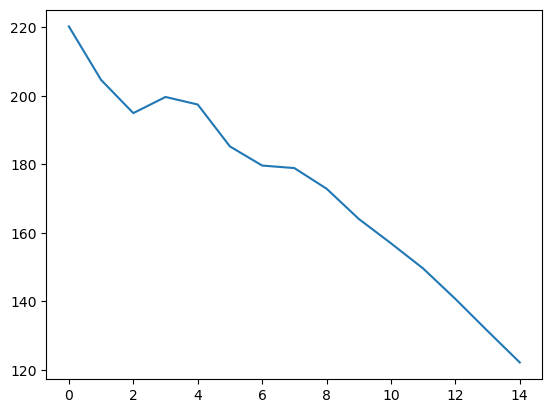

In [25]:
my_sne = SNE(Xb, perp=15)
h = my_sne.fit(2, .1, 15)
h.plot_loss()

On peut afficher Y après la dernière itération

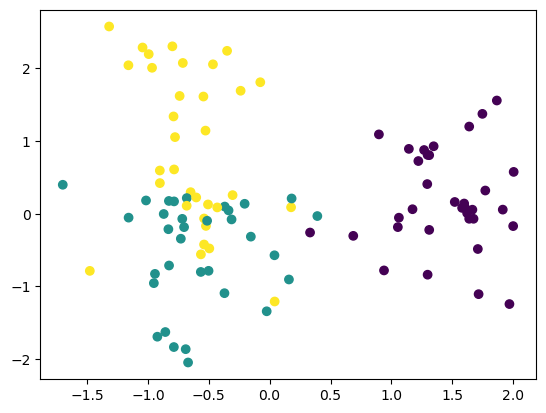

In [26]:
h.plot_Y_i(yb)

Comme 15 itérations ne sont pas assez, on peut augmenter son nombre tout en repartant du dernier Y trouvé précédemment 

0.002s, Itération 5/100, loss: 110.75689136481512
0.002s, Itération 10/100, loss: 107.18777615339519
0.014s, Itération 15/100, loss: 103.52015717997921
0.019s, Itération 20/100, loss: 99.68104651286342
0.023s, Itération 25/100, loss: 95.76882732893412
0.029s, Itération 30/100, loss: 91.83568139008702
0.033s, Itération 35/100, loss: 87.91471868826554
0.036s, Itération 40/100, loss: 84.08487991859653
0.039s, Itération 45/100, loss: 80.43398731764363
0.042s, Itération 50/100, loss: 77.02630155435003
0.045s, Itération 55/100, loss: 73.88703539384453
0.049s, Itération 60/100, loss: 71.0069983101632
0.053s, Itération 65/100, loss: 68.37132967599686
0.056s, Itération 70/100, loss: 66.00898015781772
0.058s, Itération 75/100, loss: 63.917462998645746
0.061s, Itération 80/100, loss: 62.07496839775345
0.064s, Itération 85/100, loss: 60.45699309731153
0.066s, Itération 90/100, loss: 59.03366148848744
0.066s, Itération 95/100, loss: 57.773989875725206
0.066s, Itération 100/100, loss: 56.65119398674

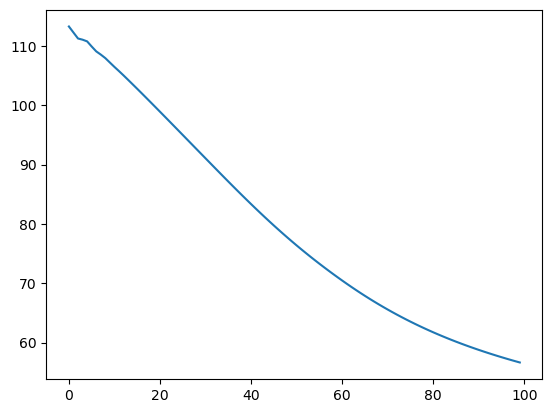

In [27]:
h2 = my_sne.fit(2, .01, 100, Y0=h.Y[-1])
h2.plot_loss()

On peut concaténer les historiques pour y voir plus clair

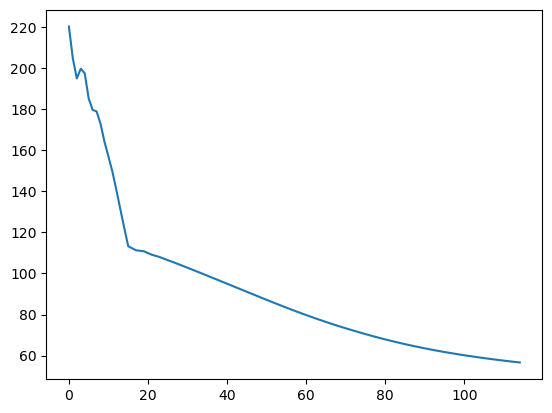

In [28]:
htot = h.concatenate(h2)
htot.plot_loss()

On peut aussi afficher le terme de momentum 

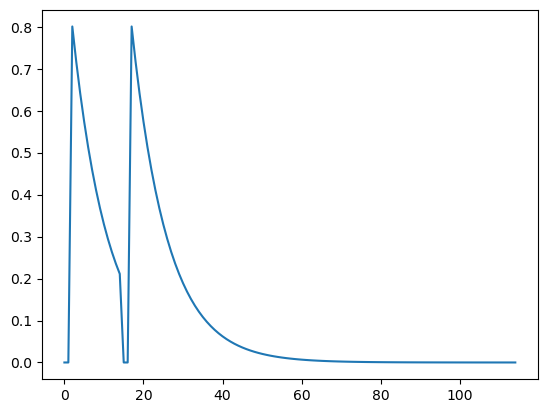

In [29]:
htot.plot_alpha()

Pour finir, on peut enregistrer un .gif de l'évolution de Y au cours des itération 

MovieWriter ffmpeg unavailable; using Pillow instead.


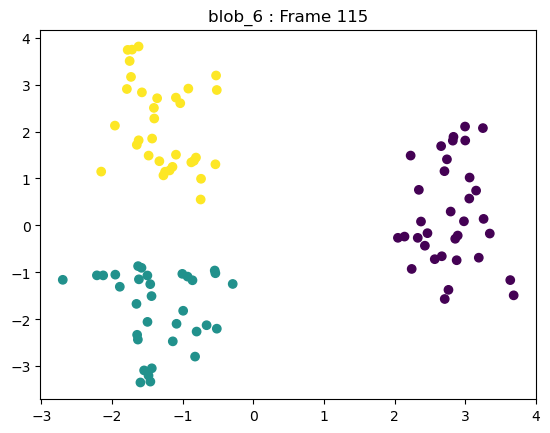

In [30]:
htot.anim_Y(yb, "blob_6", folder="./data/sne", prop=5)

### Sur les digits

In [31]:
indexes = np.random.choice(len(Xd), replace=False, size=200)
X_train, y_train = Xd[indexes], yd[indexes]

0.014s, Itération 5/1000, loss: 611.6511957052257
0.031s, Itération 10/1000, loss: 596.0181026721614
0.048s, Itération 15/1000, loss: 581.8817599040094
0.048s, Itération 20/1000, loss: 568.2844369494405
0.064s, Itération 25/1000, loss: 555.3756504352244
0.081s, Itération 30/1000, loss: 543.2077874949912
0.081s, Itération 35/1000, loss: 531.7864013906402
0.101s, Itération 40/1000, loss: 520.9503021042393
0.114s, Itération 45/1000, loss: 510.5051356488325
0.114s, Itération 50/1000, loss: 500.3982511293369
0.131s, Itération 55/1000, loss: 490.5492937830406
0.148s, Itération 60/1000, loss: 480.9600429000937
0.148s, Itération 65/1000, loss: 471.6323094776075
0.164s, Itération 70/1000, loss: 462.4864078044417
0.181s, Itération 75/1000, loss: 453.5492331140466
0.181s, Itération 80/1000, loss: 444.88192370364516
0.198s, Itération 85/1000, loss: 436.4577304586479
0.217s, Itération 90/1000, loss: 428.2684491397547
0.231s, Itération 95/1000, loss: 420.339834220525
0.257s, Itération 100/1000, loss

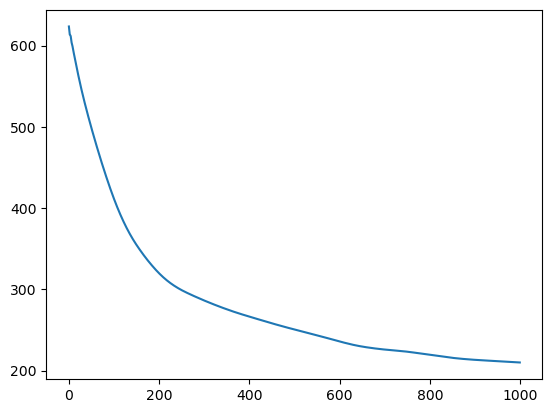

In [32]:
my_tsne = SNE(X_train, 12)
h1 = my_tsne.fit(2, .01, 1000)
h1.plot_loss()

MovieWriter ffmpeg unavailable; using Pillow instead.


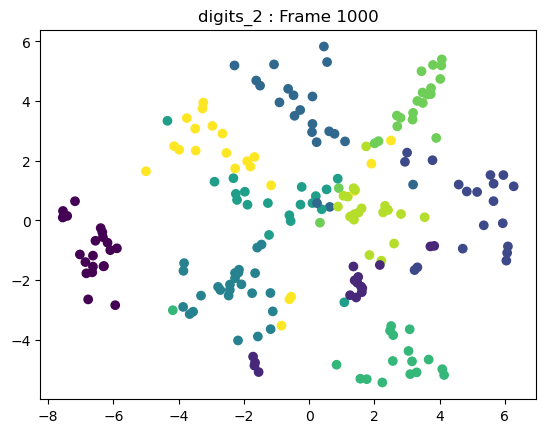

In [33]:
h1.anim_Y(y_train, "digits_2", folder="./data/sne", prop=10)

# Implémentation de T-SNE

In [34]:
class T_SNE(SNE):
    
    def __init__(self, X, perp):
        super().__init__(X, perp)
        self.P = (self.P + self.P.T) / (2 * self.n)
        
        
    def compute_Q(self, Y_table: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        self.Q = (1 + np.linalg.norm(Y_table, axis=2))**-1
        self.Q /= self.Q.sum()

    def compute_dQ(self, Y_table: npt.NDArray[np.float64]):
        dQ = (self.P - self.Q).reshape(self.n, self.n, 1) * Y_table * (1 + np.linalg.norm(Y_table))**-1
        return 4 * dQ.sum(axis = 1)

## Test de l'algo sur les données

### Sur les blobs

0.004s, Itération 5/100, loss: 191.36719477608952
0.005s, Itération 10/100, loss: 136.18006954926568
0.005s, Itération 15/100, loss: 95.67463843004604
0.005s, Itération 20/100, loss: 70.03871763896022
0.017s, Itération 25/100, loss: 59.32658082043034
0.020s, Itération 30/100, loss: 54.441138097749715
0.022s, Itération 35/100, loss: 51.018854501764366
0.022s, Itération 40/100, loss: 48.38075886046275
0.022s, Itération 45/100, loss: 46.25575398954057
0.022s, Itération 50/100, loss: 44.188561228269855
0.035s, Itération 55/100, loss: 42.51699982659398
0.038s, Itération 60/100, loss: 41.676375767135056
0.042s, Itération 65/100, loss: 41.23681242889071
0.042s, Itération 70/100, loss: 40.84835752613859
0.042s, Itération 75/100, loss: 40.58410465830754
0.051s, Itération 80/100, loss: 40.41739752660139
0.054s, Itération 85/100, loss: 40.302426918089616
0.055s, Itération 90/100, loss: 40.216153912495336
0.055s, Itération 95/100, loss: 40.148360343007695
0.055s, Itération 100/100, loss: 40.093811

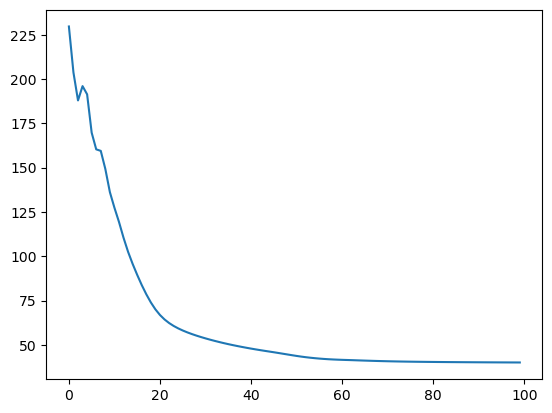

In [35]:
tsne = T_SNE(Xb, 15)
h1 = my_sne.fit(2, .1, 100)
h1.plot_loss()

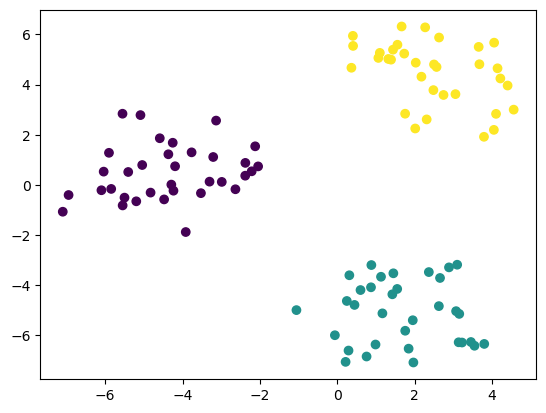

In [36]:
h1.plot_Y_i(yb)

MovieWriter ffmpeg unavailable; using Pillow instead.


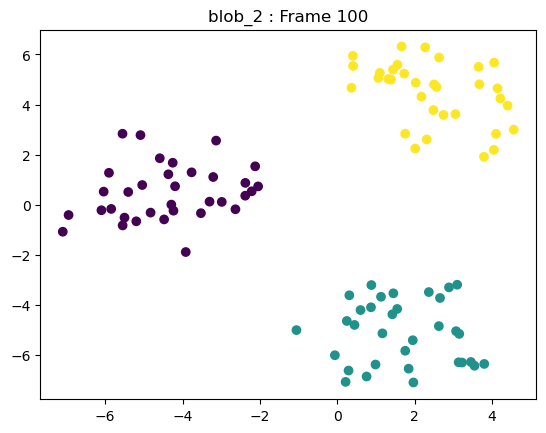

In [37]:
h1.anim_Y(yb, "blob_2", folder="./data/tsne")

### Sur les digits

In [38]:
indexes = np.random.choice(len(Xd), replace=False, size=200)
X_train, y_train = Xd[indexes], yd[indexes]

0.060s, Itération 5/15000, loss: 2.7887440040960976
0.076s, Itération 10/15000, loss: 2.7873553927891113
0.093s, Itération 15/15000, loss: 2.785860357507071
0.111s, Itération 20/15000, loss: 2.784212490483566
0.113s, Itération 25/15000, loss: 2.7824511150161713
0.136s, Itération 30/15000, loss: 2.78061114907716
0.146s, Itération 35/15000, loss: 2.778716238156635
0.156s, Itération 40/15000, loss: 2.776785429333078
0.160s, Itération 45/15000, loss: 2.7748300951308336
0.185s, Itération 50/15000, loss: 2.7728567598028304
0.193s, Itération 55/15000, loss: 2.7708685531693416
0.214s, Itération 60/15000, loss: 2.7688683945265575
0.232s, Itération 65/15000, loss: 2.7668577618260057
0.243s, Itération 70/15000, loss: 2.7648357244947452
0.246s, Itération 75/15000, loss: 2.7628058501056603
0.269s, Itération 80/15000, loss: 2.7607648759351493
0.285s, Itération 85/15000, loss: 2.7587135368781683
0.298s, Itération 90/15000, loss: 2.7566527309722635
0.315s, Itération 95/15000, loss: 2.754581559965724
0

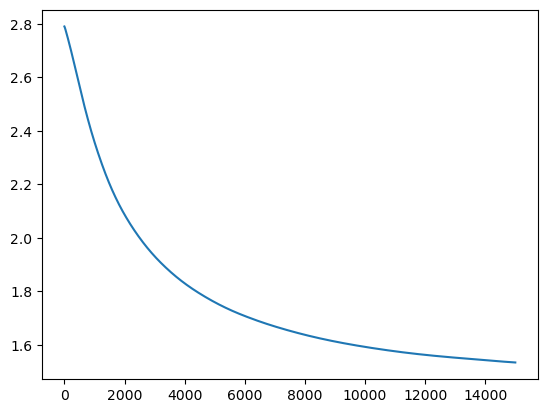

In [44]:
my_tsne = T_SNE(X_train, 12)
h = my_tsne.fit(2, 50, 15000)
h.plot_loss()

MovieWriter ffmpeg unavailable; using Pillow instead.


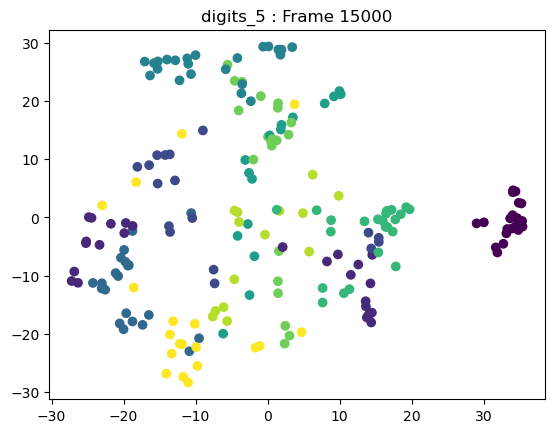

In [40]:
h.anim_Y(y_train, "digits_5", folder="./data/tsne", prop=150)